In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [21]:
df = (
    pd.read_csv("data/baseline_energy_sam.csv", index_col=[0, 1], header=[0, 1])
    .map(float)
    .fillna(0)
)
assert np.allclose(df.sum(axis=0), df.sum(axis=1))

In [4]:
sectors = ["Ag", "Ind", "Serv"]
n_sectors = len(sectors)
coords = {"i": sectors, "j": sectors}

In [5]:
variable_info = [
    # Firm variables (7)
    Variable(name="Y", dims="i", description="Final output in the <dim:i> sector"),
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demand in the <dim:i> sector",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demand in the <dim:i> sector",
    ),
    Variable(
        name="KE_d",
        dims="i",
        extend_subscript=True,
        description="Capital energy demand in the <dim:i> sector",
    ),
    Variable(
        name="E_d",
        dims="i",
        extend_subscript=True,
        description="Energy in the <dim:i> sector",
    ),
    Variable(
        name="I_d",
        dims="i",
        extend_subscript=True,
        description="Investment capital demanded by the <dim:i> sector",
    ),
    # Prices (7)
    Variable(name="P", dims="i", description="Final good price in the <dim:i> sector, after taxes"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the value-add component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:i> sector",
    ),
    Variable(
        name="P_Y",
        dims="i",
        extend_subscript=True,
        description="Final good price in the <dim:i> sector, before taxes",
    ),
    Variable(
        name="P_KE",
        dims="i",
        extend_subscript=True,
        description="Price of the intermediate capital energy bundle in sector <dim:i>",
    ),
    Variable(name="P_E", description="Price of energy"),
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    # Household Variables (6)
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of <dim:i> goods"),
    Variable(
        name="I_s", extend_subscript=True, description="Investment capital supplied by households"
    ),
    Variable(name="S", description="Household savings"),
    Variable(name="income", latex_name="Omega", description="Household income, before taxes"),
    Variable(
        name="net_income", latex_name="\hat{\Omega}", description="Household income, after taxes"
    ),
    # Government variables (3)
    Variable(name="G", description="Government budget"),
    Variable(
        name="C_G",
        dims="i",
        extend_subscript=True,
        description="Government consumption of <dim:i> goods",
    ),
    Variable(
        name="S_G",
        extend_subscript=True,
        positive=None,
        description="Investment capital supplied by government",
    ),
    # Misc (1)
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]


param_info = [
    # Production Parameters
    Parameter(
        "alpha_VA",
        dims="i",
        description="Share of capital in production of the <dim:i> sector value-add bundle",
    ),
    Parameter(
        "alpha_KE",
        dims="i",
        description="Share of capital in production of the <dim:i> sector capital-energy bundle",
    ),
    Parameter(
        "alpha_k",
        dims="i",
        extend_subscript=True,
        description="Share of capital investment demanded by the <dim:i> sector",
    ),
    Parameter("A_VA", dims="i", description="Total factor productivity VA of the <dim:i> sector"),
    Parameter("A_KE", dims="i", description="Total factor productivity KE of the <dim:i> sector"),
    Parameter(
        "psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of value-add bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of value chain bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of <dim:j> sector final goods in the <dim:i> value chain bundle",
    ),
    Parameter(
        name="phi_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(
        name="phi_KE",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector KE bundle",
    ),
    # Tax parameters
    Parameter("tau", dims="i", description="Sales tax rate on final goods in the <dim:i> sector"),
    Parameter("tau_income", latex_name=r"\tau_{\Omega}", description="Income tax rate"),
    # Household parameters
    Parameter(
        "gamma",
        dims="i",
        description="Household elasticity of consumption utility for <dim:i> sector goods",
    ),
    Parameter("mps", latex_name="phi", description="Household marginal propensity to save"),
    # Government parameters
    Parameter(
        "alpha_G",
        dims="i",
        description="Share of <dim:i> sector final goods in governmnet consumption",
    ),
    # Exogenous values
    Parameter("L_s", description="Exogenous labor supply"),
    Parameter("K_s", description="Exogenous capital supply"),
    Parameter("E_s", description="Exogenous energy supply"),
    Parameter("P_Ag_bar", latex_name=r"\bar{P}_{Ag}", description="Numeraire price"),
    Parameter(
        "S_G_bar",
        latex_name=r"\bar{S}_G",
        description="Exogenous level of governmnet savings",
        positive=None,
    ),
]

equations = [
    # Firms
    Equation("Final good production of sector <dim:i>", "P_Y * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for labor-capital", "VA = psi_VA * Y"),
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        # "VC[None] * P_VC[None] = (P[:, None] * X).sum(axis=0).ravel()",
        "VC * P_VC = Sum(P.subs({i:j}) * X.subs([(i,k), (j,i), (k,j)]), "
        + f"(j, 0, {n_sectors - 1}))",
    ),
    # Equation("Sector <dim:i> demand for sector <dim:j> intermediate input", "X = psi_X * VC[None]"),
    Equation(
        "Sector <dim:i> demand for sector <dim:j> intermediate input", "X = psi_X * VC.subs({i:j})"
    ),
    # Value add bundle
    Equation(
        "Sector <dim:i> production of labor-capital",
        "VA = A_VA * (alpha_VA * KE_d**((phi_VA - 1) / phi_VA) +"
        "(1 - alpha_VA) * L_d**((phi_VA - 1) / phi_VA)) ** (phi_VA / (phi_VA - 1))",
    ),
    Equation(
        "Sector <dim:i> demand for capital energy bundle",
        "KE_d = VA / A_VA * (alpha_VA * P_VA * A_VA / P_KE) ** phi_VA",
    ),
    Equation(
        "Sector <dim:i> demand for labor",
        "L_d = VA/ A_VA * ((1 - alpha_VA) * A_VA * P_VA / w) ** phi_VA",
    ),
    # KE bundle
    Equation(
        "Setor <dim:i> production of capital and energy",
        "KE_d = A_KE * (alpha_KE * K_d ** ((phi_KE - 1) / phi_KE) +"
        "(1 - alpha_KE) * E_d **((phi_KE - 1) / phi_KE)) ** (phi_KE / (phi_KE - 1))",
    ),
    Equation(
        "Sector <dim:i> demand for captial",
        "K_d = KE_d / A_KE * (alpha_KE * P_KE * A_KE / r) ** phi_KE",
    ),
    Equation(
        "Sector <dim:i> demand for energy",
        "E_d = KE_d / A_KE * ((1 - alpha_KE) * P_KE * A_KE / P_E) ** phi_KE",
    ),
    Equation("<dim:i> sector demand for investment capital", "P * I_d = alpha_k * I_s"),
    # Government block
    Equation(
        "Government budget constraint",
        # "G + S_G = tau_income * income + (tau * P_Y * Y).sum()",
        "G + S_G = tau_income * income + Sum(tau * P_Y * Y, " + f"(i, 0, {n_sectors-1}))",
    ),
    Equation("Government consumption of <dim:i> sector goods", "P * C_G = alpha_G * G"),
    Equation("Sector <dim:i> after-tax price", "P = (1 + tau) * P_Y"),
    Equation("Exogenous government savings", "S_G = S_G_bar"),
    # Household block
    Equation("Household pre-tax income", "income = w * L_s + r * K_s + P_E * E_s"),
    Equation("Household after-tax income", "net_income = (1 - tau_income) * income"),
    # Equation("Household utility", "U = (C**gamma).prod()"),
    Equation("Household utility", "U = Product(C**gamma, " + f"(i, 0, {n_sectors - 1}))"),
    Equation("Household demand for good <dim:i>", "C * P = gamma * (1 - mps) * net_income"),
    Equation("Household savings", "S = mps * net_income"),
    # Economic equilibrium
    Equation("Investment market clearing", "I_s = S + S_G + resid"),
    # Equation("Labor market clearing", "L_s = L_d.sum()"),
    Equation("Labour market clearing", "L_s = Sum(L_d, " + f"(i, 0, {n_sectors - 1}))"),
    # Equation("Capital market clearing", "K_s = K_d.sum()"),
    Equation("Capital market clearing", f"K_s = Sum(K_d, (i, 0, {n_sectors - 1}))"),
    # Equation("<dim:i> sector goods market clearing", "Y = C + X.sum(axis=1) + C_G + I_d"),
    Equation(
        "Sector <dim:i> goods market clearing",
        f"Y = C_G + I_d + C + Sum(X, (j, 0, {n_sectors - 1}))",
    ),
    Equation(
        "Sector <dim:i> energy endowement",
        # "E_s = E_d.sum(axis=0)",
        f"E_s = Sum(E_d, (i, 0, {n_sectors - 1}))",
    ),
    # Equation("Numeraire", "P[0] = P_Ag_bar"),
    Equation("Numeraire", "P.subs({i:'Ag'}) = P_Ag_bar"),
]

In [6]:
mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=True,
    backend="numba",
    # mode="JAX",
    compile=True,
)

In [7]:
assert len(mod.unpacked_variable_names) == len(mod.unpacked_equation_names)

In [8]:
from copy import deepcopy


def calibrate_model(
    income_tax_revenue,
    sales_tax_revenue,
    S,
    S_G,
    L_d,
    K_d,
    E_d,
    C,
    C_G,
    Y,
    X,
    I_d,
    phi_VA,
    phi_KE,
    variables,
    parameters,
):
    rho_VA = (phi_VA - 1) / phi_VA
    rho_KE = (phi_KE - 1) / phi_KE

    # Normalize prices to 1
    w = 1.0
    r = 1.0
    P_E = 1.0
    P_VA = np.ones(n_sectors)
    P_VC = np.ones(n_sectors)
    P_Y = np.ones(n_sectors)
    P_KE = np.ones(n_sectors)

    # Zero the residual
    resid = 0.0

    # Factor supplies
    L_s = L_d.sum()
    K_s = K_d.sum()
    E_s = E_d.sum()

    # Tax rates
    tau = sales_tax_revenue / (Y - sales_tax_revenue)
    P = P_Y * (1 + tau)

    # Numeraire
    P_Ag_bar = P[0]

    X /= P[:, None]
    C /= P
    C_G /= P
    I_d /= P
    Y /= P

    # Firm calibration
    KE_d = (P_E * E_d + r * K_d) / P_KE
    VA = (w * L_d + r * KE_d) / P_VA
    VC = (P[:, None] * X).sum(axis=0) / P_VC

    alpha_KE = r * K_d ** (1 / phi_KE) / ((r * K_d ** (1 / phi_KE) + P_E * E_d ** (1 / phi_KE)))
    alpha_VA = (
        P_KE * KE_d ** (1 / phi_VA) / ((P_KE * KE_d ** (1 / phi_VA) + w * L_d ** (1 / phi_VA)))
    )

    A_VA = VA * (alpha_VA * KE_d**rho_VA + (1 - alpha_VA) * L_d**rho_VA) ** (-1 / rho_VA)
    A_KE = KE_d * (alpha_KE * K_d**rho_KE + (1 - alpha_KE) * E_d**rho_KE) ** (-1 / rho_KE)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[None]

    income = w * L_s + r * K_s + P_E * E_s
    tau_income = income_tax_revenue / income
    net_income = (1 - tau_income) * income

    mps = S / net_income
    consumption_spend = (1 - mps) * net_income

    gamma = P * C / consumption_spend

    U = (C**gamma).prod()

    # Exogenous government spending level
    S_G_bar = S_G
    G_exog = P_E * E_s

    G = (P * C_G).sum()  # + P_E * E_s
    alpha_G = (P * C_G) / G

    I_s = (P * I_d).sum()
    alpha_k = P * I_d / I_s

    d = {}
    for obj in variables + parameters:
        d[obj.name] = deepcopy(locals()[obj.name])

    return d

In [9]:
# compute_DAG(**param_dict, Y=np.array([6000., 22_000., 15_000.]), mod=mod)

In [10]:
initial_data = {
    "income_tax_revenue": df.loc[("Institution", "Govt"), ("Institution", "Household")],
    "sales_tax_revenue": df.loc[("Institution", "Govt"), "Production"].values,
    "S": df.loc[("Other", "Capital Accumulation"), ("Institution", "Household")],
    "S_G": df.loc[("Other", "Capital Accumulation"), ("Institution", "Govt")],
    "L_d": df.loc[("Factor", "Labor"), "Activities"].values,
    "K_d": df.loc[("Factor", "Capital"), "Activities"].values,
    "E_d": df.loc[("Factor", "Energy"), "Activities"].values,
    "I_d": df.loc["Production", ("Other", "Capital Accumulation")].values,
    "C": df.loc["Production", ("Institution", "Household")].values,
    "C_G": df.loc["Production", ("Institution", "Govt")].values,
    "Y": df.loc["Production", :].sum(axis=1).values,
    "X": df.loc["Production", "Activities"].values,
}

econometric_estimates = {"phi_VA": np.ones(n_sectors) * 10.0, "phi_KE": np.ones(n_sectors) * 4.0}
initial_data = {k: deepcopy(v) for k, v in (initial_data | econometric_estimates).items()}

calibrated_data = calibrate_model(
    **initial_data, variables=mod.variables, parameters=mod.parameters
)

mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


In [11]:
from cge_modeling.base.utilities import flat_array_to_variable_dict, variable_dict_to_flat_array


var_inputs, param_inputs = variable_dict_to_flat_array(
    calibrated_data, mod.variables, mod.parameters
)
var_dict = {k: deepcopy(calibrated_data[k]) for k in mod.variable_names}
param_dict = {k: deepcopy(calibrated_data[k]) for k in mod.parameter_names}

## Policy Simulation -- Tax Cut

In [12]:
from cge_modeling.base.utilities import flat_array_to_variable_dict, variable_dict_to_flat_array
from copy import deepcopy

tax_cut = deepcopy(calibrated_data)

# 50% income tax cut
tax_cut["tau_income"] *= 0.5
_, theta_tax_cut = variable_dict_to_flat_array(tax_cut, mod.variables, mod.parameters)

In [13]:
n_steps = 100_000
idata = mod._solve_with_euler_approximation(
    calibrated_data, theta_final=theta_tax_cut, n_steps=n_steps
)

  0%|                                                | 0/100000 [00:00<?, ?it/s]

In [15]:
new_data = idata.isel(step=-1).to_dict()["variables"] | idata.isel(step=-1).to_dict()["parameters"]
mod.check_for_equilibrium(new_data)

Equilibrium found! Total squared error: 0.000000


In [16]:
from cge_modeling.base.utilities import flat_array_to_variable_dict

res = mod._solve_with_root(calibrated_data, theta_tax_cut, method="hybr", use_jac=True)
res_d = flat_array_to_variable_dict(
    np.r_[res.x, theta_tax_cut], mod.variables + mod.parameters, mod.coords
)
mod.check_for_equilibrium(res_d)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/scipy/optimize/_root.py:210: RuntimeWarning: Method hybr does not accept callback.
  warn('Method %s does not accept callback.' % method,



Equilibrium found! Total squared error: 0.000000


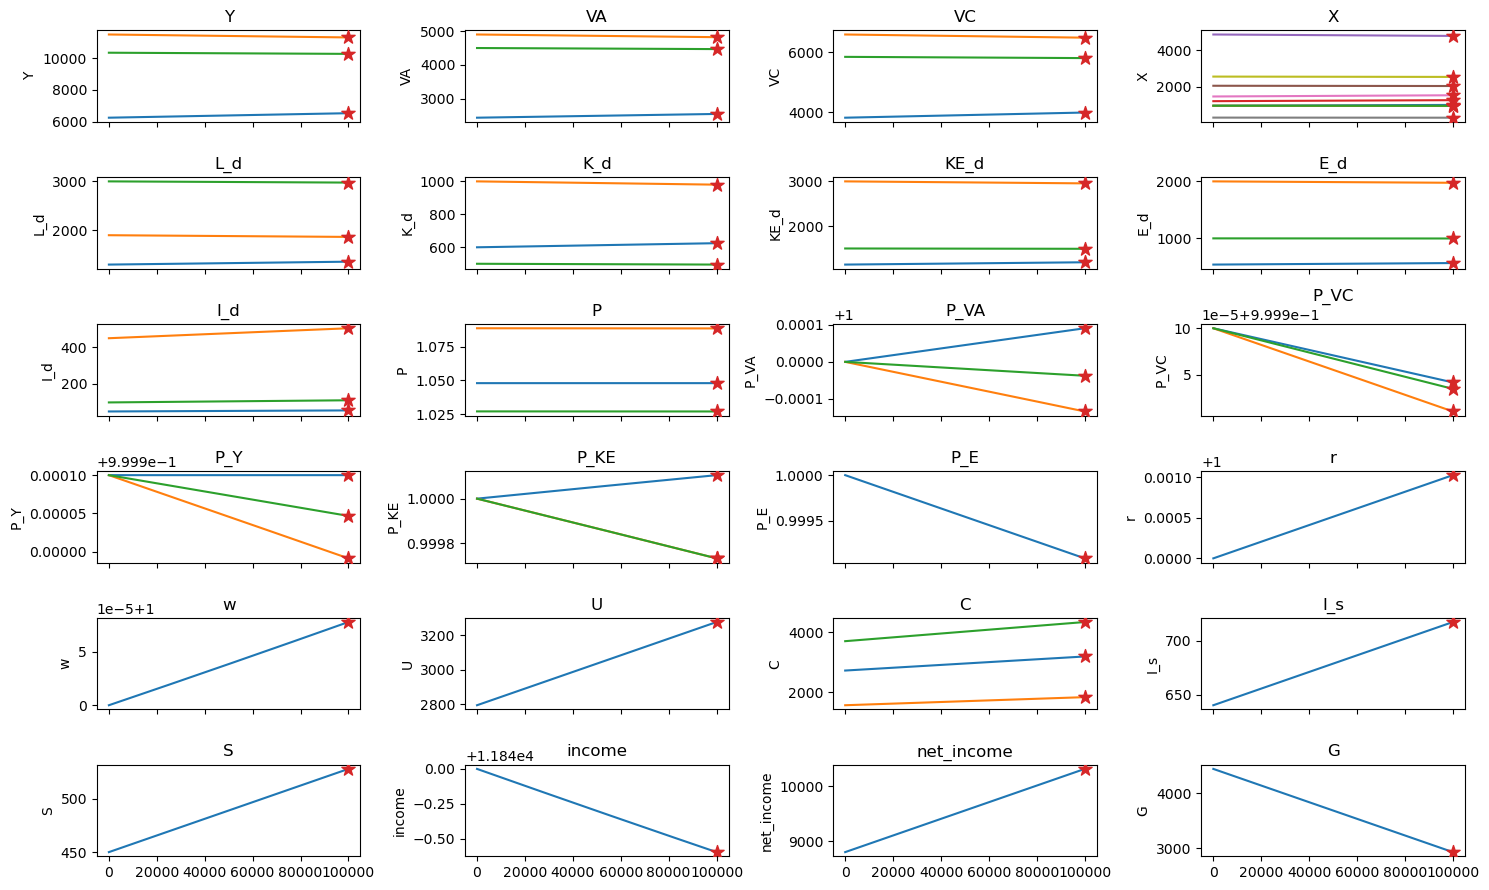

In [17]:
fig, ax = plt.subplots(6, 4, figsize=(15, 9), sharex=True)
for i, (axis, var) in enumerate(zip(fig.axes, mod.variable_names)):
    data = idata.variables[var]
    if data.ndim > 2:
        data = data.stack(pair=["i", "j"])
    data.plot.line(x="step", ax=axis, add_legend=False)
    axis.set(title=var, xlabel=None)

    scatter_grid = np.full(int(np.prod(res_d[var].shape)), idata.variables.coords["step"].max())
    axis.scatter(scatter_grid, res_d[var].ravel(), marker="*", color="tab:red", zorder=10, s=100)
fig.tight_layout()

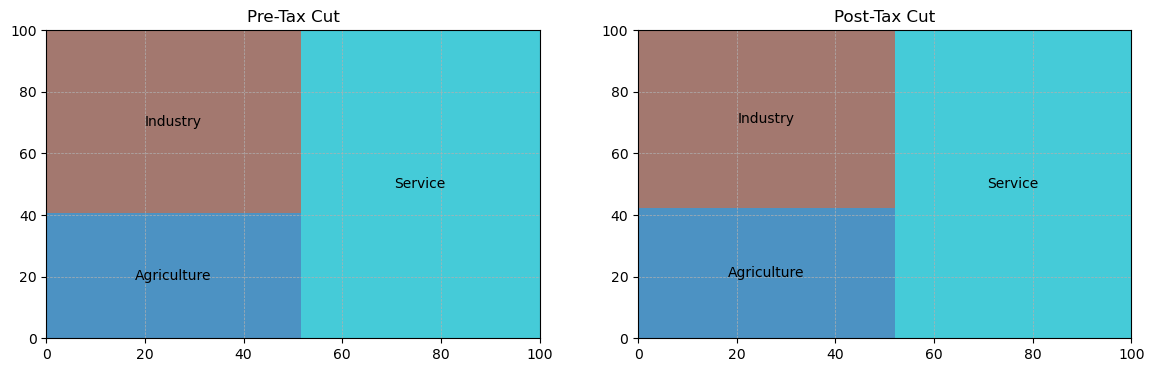

In [18]:
import squarify

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
short_to_long = {"Ag": "Agriculture", "Ind": "Industry", "Serv": "Service"}

long_sectors = [short_to_long[x] for x in sectors]
cmap = plt.cm.tab10([0, 0.5, 1.0])

squarify.plot(sizes=calibrated_data["L_d"], label=long_sectors, alpha=0.8, ax=ax[0], color=cmap)
squarify.plot(sizes=res_d["L_d"], label=long_sectors, alpha=0.8, ax=ax[1], color=cmap)
for axis, title in zip(fig.axes, ["Pre-Tax Cut", "Post-Tax Cut"]):
    axis.grid(ls="--", lw=0.5)
    axis.set(title=title)